In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    make_scorer
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore') # Suppresas warnings
RANDOM_STATE = 110

In [ ]:
!pip install pycaret[full]

## 1. 데이터불러오기

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from pycaret.classification import *

from scipy.stats import chi2_contingency
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import LabelEncoder

# Suppress warnings
warnings.filterwarnings('ignore')

In [ ]:
RANDOM_STATE = 110

## Load data
# LG 원본 데이터셋
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [ ]:
test_df = test_df.drop(['Set ID', 'target'], axis=1)

## 2. 데이터 전처리

### 2-1. 결측치 1차 처리

- 밀린 데이터를 한 칸씩 옮겨서 원상복구
- 완성된 df를 저장하기
- 해당 코드는 최초 1번만 수행하고 저장된 df를 불러와서 재사용하면 됨

#### 'OK'값을 결측값으로 처리

In [ ]:
# X좌표의 "OK"를 NaN으로 변환

columns_to_replace_ok = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'
]

# Train 데이터셋에서 "OK" 값을 NaN으로 변경
for column in columns_to_replace_ok:
    train_df[column] = train_df[column].replace('OK', np.nan).astype(float)

# Test 데이터셋에서 "OK" 값을 NaN으로 변경
for column in columns_to_replace_ok:
    test_df[column] = test_df[column].replace('OK', np.nan).astype(float)

#### 밀린 데이터를 원상복구

In [ ]:
def shift_and_fill(data, start_col, end_col, step):

    start_idx = data.columns.get_loc(start_col)

    end_idx = data.columns.get_loc(end_col)

    missing_indices = data[data[start_col].isnull()].index

    # 결측치가 있는 각 행에 대하여 처리
    for idx in missing_indices:
        current_idx = start_idx

        while current_idx <= end_idx - step:
            next_idx = current_idx + step
            data.iloc[idx, current_idx] = data.iloc[idx, next_idx]
            current_idx = next_idx

        data.iloc[idx, end_idx] = np.nan

In [ ]:
#Dam
shift_and_fill(train_df, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
               'WorkMode Collect Result_Dam', 3)
shift_and_fill(test_df, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
               'WorkMode Collect Result_Dam', 3)
#Fill1
shift_and_fill(train_df, "HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1",
               'WorkMode Collect Result_Fill1', 3)
shift_and_fill(test_df, "HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1",
               'WorkMode Collect Result_Fill1', 3)

#Fill2
shift_and_fill(train_df, "HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2",
               'WorkMode Collect Result_Fill2', 3)
shift_and_fill(test_df, "HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2",
               'WorkMode Collect Result_Fill2', 3)


In [ ]:
# 마지막 열 채워주기

# train_data
train_df['WorkMode Collect Result_Fill1'] = 7
train_df['WorkMode Collect Result_Dam'] = 7
train_df['WorkMode Collect Result_Fill2'] = 0

# test_data
test_df['WorkMode Collect Result_Fill1'] = 7
test_df['WorkMode Collect Result_Dam'] = 7
test_df['WorkMode Collect Result_Fill2'] = 0


### 2-2. 의미있는 'OK'값 처리

In [ ]:
def process_ok_columns(df, col):
    # 'OK' 값을 1로 변경(인코딩)
    df[col].replace('OK', 1, inplace=True)

    # 결측값을 0으로 채우기
    df[col].fillna(0, inplace=True)

    # 'NG' 값을 0으로 변경(인코딩)
    df[col].replace('NG', 0, inplace=True)

cols = ['Chamber Temp. Judge Value_AutoClave', 'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave']
process_ok_columns(train_df, cols[0])
process_ok_columns(test_df,  cols[0])
process_ok_columns(train_df, cols[1])
process_ok_columns(test_df,  cols[1])

### 2-3. 여러 공정에 있는 동일한 컬럼을 1개로 통일

> - Model.Suffix (모든 공정)
- PalletID (모든 공정)
- Workorder (모든 공정)
- Production Qty (모든 공정)
- Receip No (모든 공정)

In [ ]:
##############################################
### 1. Equipment 인코딩
# Equipment_Dam 컬럼에서 #1을 포함하는 값은 0으로, #2를 포함하는 값은 1로 변환
def convert_equipment_values(row):
    if '#1' in str(row):
        return 0
    elif '#2' in str(row):
        return 1
    return row  # #1 또는 #2를 포함하지 않는 경우 원래 값 유지

train_df['Equipment_Dam'] = train_df['Equipment_Dam'].apply(convert_equipment_values)
train_df['Equipment_Fill1'] = train_df['Equipment_Fill1'].apply(convert_equipment_values)
train_df['Equipment_Fill2'] = train_df['Equipment_Fill2'].apply(convert_equipment_values)

test_df['Equipment_Dam'] = test_df['Equipment_Dam'].apply(convert_equipment_values)
test_df['Equipment_Fill1'] = test_df['Equipment_Fill1'].apply(convert_equipment_values)
test_df['Equipment_Fill2'] = test_df['Equipment_Fill2'].apply(convert_equipment_values)

# 컬럼 그룹 정의
equipment_cols = ['Equipment_Dam', 'Equipment_Fill1', 'Equipment_Fill2']
model_suffix_cols = [col for col in train_df.columns if "Model.Suffix" in col]
workorder_cols = [col for col in train_df.columns if "Workorder" in col]
receip_no_cols = [col for col in train_df.columns if "Receip No Collect Result" in col]
pallet_id_cols = [col for col in train_df.columns if "PalletID" in col]
production_qty_cols = [col for col in train_df.columns if "Production" in col]

# 컬럼 그룹을 딕셔너리로 관리
columns_groups = {
    'Model Suffix': model_suffix_cols,
    'Workorder': workorder_cols,
    'Receip No': receip_no_cols,
    'Pallet ID': pallet_id_cols,
    'Production Qty': production_qty_cols,
    'Equipment': equipment_cols  # 추가된 그룹
}


##############################################
### 2. 불일치 ROWS 제거
# 주어진 컬럼 그룹에서 서로 다른 값을 찾는 함수
def find_differences(data, columns):
    if not columns:
        return None  # 주어진 컬럼 그룹이 비어있는 경우 None 반환
    comparison_df = data[columns]
    diff_rows = comparison_df[comparison_df.nunique(axis=1) > 1]  # 행별로 유일한 값의 수를 계산, 1보다 크면 다름
    #print(f'✅ 불일치한 경우의 df shape: (len(rows), len(cols)) = {diff_rows.shape}}')
    print(f'✅ <불일치한 경우> 총 {len(diff_rows)}개 rows가 불일치함. 비교한 {len(diff_rows.columns)}개 columns 정보: {diff_rows.columns.to_list()}')
    return

# 행 제거 함수
def remove_inconsistent_rows(data, columns_groups):
    for key, cols in columns_groups.items():
        diff_rows = find_differences(data, cols)
        if diff_rows is not None:
            data.drop(diff_rows.index, inplace=True)
    return data

train_df = remove_inconsistent_rows(train_df, columns_groups)


##############################################
### 3. 중복 COLUMNS 제거
# => 마지막에 feature group 어차피 선택할거라 걍 skip
'''
remove_cols = ['Model.Suffix_AutoClave', 'Model.Suffix_Fill1', 'Model.Suffix_Fill2',
               'Equipment_Fill1', 'Equipment_Fill2',
               'Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2',
               'Receip No Collect Result_Fill1', 'Receip No Collect Result_Fill2',
               'Production Qty Collect Result_Fill1', 'Production Qty Collect Result_Fill2',
               'PalletID Collect Result_Fill1','PalletID Collect Result_Fill2']

# 결과 출력
print("삭제 전:")
print(train_df.shape)
print(test_df.shape)

# 삭제
train_df = train_df.drop(columns=remove_cols)
test_df  = test_df.drop(columns=remove_cols)

# 결과 출력
print("삭제 후:")
print(train_df.shape)
print(test_df.shape)
'''

✅ <불일치한 경우> 총 0개 rows가 불일치함. 비교한 4개 columns 정보: ['Model.Suffix_Dam', 'Model.Suffix_AutoClave', 'Model.Suffix_Fill1', 'Model.Suffix_Fill2']
✅ <불일치한 경우> 총 0개 rows가 불일치함. 비교한 4개 columns 정보: ['Workorder_Dam', 'Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2']
✅ <불일치한 경우> 총 4개 rows가 불일치함. 비교한 3개 columns 정보: ['Receip No Collect Result_Dam', 'Receip No Collect Result_Fill1', 'Receip No Collect Result_Fill2']
✅ <불일치한 경우> 총 83개 rows가 불일치함. 비교한 9개 columns 정보: ['PalletID Collect Result_Dam', 'PalletID Unit Time_Dam', 'PalletID Judge Value_Dam', 'PalletID Collect Result_Fill1', 'PalletID Unit Time_Fill1', 'PalletID Judge Value_Fill1', 'PalletID Collect Result_Fill2', 'PalletID Unit Time_Fill2', 'PalletID Judge Value_Fill2']
✅ <불일치한 경우> 총 93개 rows가 불일치함. 비교한 9개 columns 정보: ['Production Qty Collect Result_Dam', 'Production Qty Unit Time_Dam', 'Production Qty Judge Value_Dam', 'Production Qty Collect Result_Fill1', 'Production Qty Unit Time_Fill1', 'Production Qty Judge Value_Fill1', 'Produ

'\nremove_cols = [\'Model.Suffix_AutoClave\', \'Model.Suffix_Fill1\', \'Model.Suffix_Fill2\',\n               \'Equipment_Fill1\', \'Equipment_Fill2\',\n               \'Workorder_AutoClave\', \'Workorder_Fill1\', \'Workorder_Fill2\',\n               \'Receip No Collect Result_Fill1\', \'Receip No Collect Result_Fill2\',\n               \'Production Qty Collect Result_Fill1\', \'Production Qty Collect Result_Fill2\',\n               \'PalletID Collect Result_Fill1\',\'PalletID Collect Result_Fill2\']\n\n# 결과 출력\nprint("삭제 전:")\nprint(train_df.shape)\nprint(test_df.shape)\n\n# 삭제\ntrain_df = train_df.drop(columns=remove_cols)\ntest_df  = test_df.drop(columns=remove_cols)\n\n# 결과 출력\nprint("삭제 후:")\nprint(train_df.shape)\nprint(test_df.shape)\n'

### 2-4. 고윳값이 1개인 컬럼 삭제
- 모든 rows에 동일한 값만 들어있는 column은 분류에 아무 영향을 안 줌

In [ ]:
print("삭제 전:")
print(train_df.shape)
print(test_df.shape)


### 고유치가 1개인 컬럼 제거
# unique data가 1개 이하만 들어있는 컬럼
unique_counts = train_df.nunique()
tr_cols_to_drop = unique_counts[unique_counts <= 1].index

# unique data가 1개 이하만 들어있는 컬럼
unique_counts = test_df.nunique()
te_cols_to_drop = unique_counts[unique_counts <= 1].index

# 1개 이하만 들어있는 컬럼 삭제
train_df = train_df.drop(columns=tr_cols_to_drop)
test_df  = test_df.drop(columns=te_cols_to_drop)



### 장치#1, 장치#2에 따라 각각 고유값이 1개인 컬럼 제거
def remove_single_value_columns(df):
    # Equipment_Dam 값에 따른 데이터 분할
    group_0 = df[df['Equipment_Dam'] == 0]
    group_1 = df[df['Equipment_Dam'] == 1]

    # 유니크한 값이 1인 컬럼을 찾고 제거하는 함수
    def find_single_value_columns(data):
        columns_to_remove = []
        for col in data.columns:
            # Equipment_Dam 컬럼은 제외
            if col != 'Equipment_Dam' and len(data[col].unique()) == 1:
                columns_to_remove.append(col)
        return columns_to_remove

    # 각 그룹에 대해 유니크한 값이 1인 컬럼 찾기
    columns_to_remove_0 = find_single_value_columns(group_0)
    columns_to_remove_1 = find_single_value_columns(group_1)

    # 두 그룹에서 공통으로 제거할 컬럼 찾기
    common_columns_to_remove = list(set(columns_to_remove_0) & set(columns_to_remove_1))

    # 공통 컬럼 제거
    return df.drop(columns=common_columns_to_remove, inplace=False), common_columns_to_remove


train_df, train_removed_cols = remove_single_value_columns(train_df)
test_df = test_df.drop(columns=train_removed_cols, errors='ignore')


# 결과 출력
print("삭제 후:")
print(train_df.shape)
print(test_df.shape)

삭제 전:
(40506, 464)
(17361, 463)
삭제 후:
(40506, 115)
(17361, 114)


### 2-5. OK값 결측치 처리

In [ ]:
# 결과 출력
print("삭제 전:")
print(train_df.shape)
print(test_df.shape)


### 1. 'OK' 값을 NaN으로 변환
train_df.replace('OK', np.nan, inplace=True)
test_df.replace('OK', np.nan, inplace=True)


### 2. 모든 값이 결측치인 컬럼 삭제
# 모든 값이 결측값인 컬럼을 제거하는 함수
def remove_all_missing_columns(data):
    # 결측값이 모든 행에 있는 컬럼만 True로 표시됩니다.
    is_all_missing = data.isnull().all()
    # True가 아닌 컬럼만 선택하여 데이터프레임을 새로 생성합니다.
    cleaned_data = data.loc[:, ~is_all_missing]
    return cleaned_data

train_df = remove_all_missing_columns(train_df)
test_df = remove_all_missing_columns(test_df)


# 결과 출력
print("삭제 후:")
print(train_df.shape)
print(test_df.shape)

삭제 전:
(40506, 115)
(17361, 114)
삭제 후:
(40506, 115)
(17361, 114)


## 3. 피쳐 추출

In [ ]:

train_df = train_df[['Production Qty Collect Result_Dam','Workorder_AutoClave', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1',
                     'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1',
                     'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1','DISCHARGED SPEED OF RESIN Collect Result_Fill1'
                     ,'target']]
test_df = test_df[['Production Qty Collect Result_Dam','Workorder_AutoClave', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1',
                     'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1',
                     'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1','DISCHARGED SPEED OF RESIN Collect Result_Fill1'
                     ]]

## 4. 모델

In [ ]:
import optuna
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np
from collections import defaultdict
from joblib import Parallel, delayed

### AutoML 모델 실험

In [ ]:
train_split_df, valid_df = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df["target"],
    random_state=RANDOM_STATE,
)

y_train = train_split_df['target']
X_train = train_split_df.drop('target', axis=1)

y_valid = valid_df['target']
X_valid = valid_df.drop('target', axis=1)



clf = setup(data=X_train, target=y_train, session_id=RANDOM_STATE, n_jobs=4)

kfold = 10

def my_tune_model(model_name, fold, n_iter, optimize):
  m = create_model(model_name, fold = kfold)
  return tune_model(m, fold = kfold, n_iter = n_iter, optimize = optimize)


model_list = []
#for model_name in ['catboost', 'rf', 'et', 'lightgbm', 'xgboost', 'gbc', 'ada', 'knn', 'lda']:
for model_name in ['gbc','catboost', 'rf', 'lightgbm', 'xgboost']:
  model_list.append(my_tune_model(model_name, fold = kfold, n_iter =10, optimize = 'F1'))

kfold = 10
blended_model = blend_models(estimator_list = model_list,
                       fold = kfold,
                       method = 'soft',
                       optimize='F1'
                       )

,Description,Value
0,Session id,110
1,Target,target
2,Target type,Binary
3,Target mapping,"AbNormal: 0, Normal: 1"
4,Original data shape,"(32404, 7)"
5,Transformed data shape,"(32404, 7)"
6,Transformed train set shape,"(22682, 7)"
7,Transformed test set shape,"(9722, 7)"
8,Numeric features,5
9,Categorical features,1


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9427,0.6770,0.9427,0.9318,0.9166,0.0408,0.1242
1,0.9427,0.6386,0.9427,0.9318,0.9166,0.0408,0.1242
2,0.9444,0.6597,0.9444,0.9329,0.9217,0.1047,0.2004
3,0.9422,0.6031,0.9422,0.9178,0.9167,0.0389,0.0976
4,0.9444,0.6680,0.9444,0.9397,0.9203,0.0816,0.1907
5,0.9427,0.6431,0.9427,0.9223,0.9177,0.0524,0.1225
6,0.9440,0.7080,0.9440,0.9350,0.9204,0.0925,0.1940
7,0.9418,0.6585,0.9418,0.9168,0.9153,0.0261,0.0793
8,0.9436,0.6521,0.9436,0.9329,0.9194,0.0796,0.1758


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9431,0.6826,0.9431,0.9464,0.9168,0.0420,0.1464
1,0.9418,0.6398,0.9418,0.9172,0.9161,0.0386,0.0972
2,0.9436,0.6607,0.9436,0.9310,0.9190,0.0670,0.1566
3,0.9427,0.6063,0.9427,0.9236,0.9169,0.0400,0.1093
4,0.9431,0.6702,0.9431,0.9464,0.9164,0.0284,0.1200
5,0.9431,0.6425,0.9431,0.9258,0.9188,0.0657,0.1447
6,0.9444,0.7043,0.9444,0.9475,0.9199,0.0823,0.2072
7,0.9418,0.6571,0.9418,0.9168,0.9153,0.0261,0.0793
8,0.9422,0.6515,0.9422,0.9217,0.9171,0.0520,0.1220


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9423,0.6814,0.9423,0.9210,0.9186,0.0756,0.1453
1,0.9423,0.6342,0.9423,0.9212,0.9179,0.0640,0.1341
2,0.9458,0.6598,0.9458,0.9375,0.9246,0.1422,0.2459
3,0.9422,0.5949,0.9422,0.9185,0.9183,0.0632,0.1262
4,0.9414,0.6482,0.9414,0.9137,0.9178,0.0608,0.1122
5,0.9427,0.6394,0.9427,0.9218,0.9185,0.0645,0.1347
6,0.9453,0.7004,0.9453,0.9429,0.9226,0.1195,0.2393
7,0.9427,0.6592,0.9427,0.9253,0.9181,0.0652,0.1440
8,0.9400,0.6488,0.9400,0.9095,0.9166,0.0580,0.1006


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9409,0.6669,0.9409,0.9150,0.9186,0.0831,0.1366
1,0.9431,0.6356,0.9431,0.9253,0.9213,0.1119,0.1888
2,0.9449,0.6440,0.9449,0.9317,0.9240,0.1388,0.2275
3,0.9405,0.5958,0.9405,0.9116,0.9180,0.0699,0.1146
4,0.9422,0.6353,0.9422,0.9212,0.9230,0.1394,0.1960
5,0.9409,0.6319,0.9409,0.9150,0.9196,0.0934,0.1431
6,0.9431,0.7026,0.9431,0.9248,0.9232,0.1432,0.2119
7,0.9427,0.6639,0.9427,0.9231,0.9210,0.1104,0.1816
8,0.9409,0.6508,0.9409,0.9165,0.9199,0.1047,0.1578


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9211,0.6505,0.9211,0.9029,0.9112,0.1052,0.1094
1,0.9246,0.6391,0.9246,0.9035,0.9129,0.1057,0.1124
2,0.9321,0.6437,0.9321,0.9131,0.9207,0.1752,0.1882
3,0.9228,0.6116,0.9228,0.9066,0.9140,0.1326,0.1371
4,0.9286,0.6176,0.9286,0.9109,0.9185,0.1641,0.1726
5,0.9255,0.6256,0.9255,0.9078,0.9156,0.1397,0.1460
6,0.9246,0.7068,0.9246,0.9119,0.9176,0.1882,0.1922
7,0.9242,0.6243,0.9242,0.9089,0.9157,0.1587,0.1637
8,0.9224,0.5989,0.9224,0.9058,0.9133,0.1317,0.1362


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9431,0.6797,0.9431,0.9464,0.9168,0.0420,0.1464
1,0.9431,0.6430,0.9431,0.9464,0.9168,0.0420,0.1464
2,0.9431,0.6575,0.9431,0.9323,0.9172,0.0412,0.1247
3,0.9427,0.6041,0.9427,0.9271,0.9161,0.0273,0.0950
4,0.9431,0.6675,0.9431,0.9464,0.9164,0.0284,0.1200
5,0.9427,0.6433,0.9427,0.9460,0.9153,0.0143,0.0848
6,0.9418,0.7048,0.9418,0.8870,0.9136,0.0000,0.0000
7,0.9422,0.6626,0.9422,0.9265,0.9155,0.0271,0.0946
8,0.9418,0.6479,0.9418,0.9168,0.9153,0.0261,0.0793


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9423,0.6749,0.9423,0.9231,0.9163,0.0397,0.1088
1,0.9436,0.6320,0.9436,0.9330,0.9194,0.0796,0.1758
2,0.9436,0.6554,0.9436,0.9272,0.9205,0.0905,0.1731
3,0.9427,0.5964,0.9427,0.9236,0.9169,0.0400,0.1093
4,0.9431,0.6527,0.9431,0.9258,0.9188,0.0657,0.1447
5,0.9436,0.6475,0.9436,0.9286,0.9198,0.0789,0.1647
6,0.9453,0.7040,0.9453,0.9483,0.9219,0.1084,0.2393
7,0.9431,0.6669,0.9431,0.9305,0.9184,0.0665,0.1559
8,0.9405,0.6479,0.9405,0.9096,0.9161,0.0474,0.0911


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9423,0.6736,0.9423,0.9231,0.9163,0.0397,0.1088
1,0.9427,0.6396,0.9427,0.9273,0.9174,0.0532,0.1339
2,0.9431,0.6580,0.9431,0.9278,0.9180,0.0536,0.1344
3,0.9427,0.6019,0.9427,0.9271,0.9161,0.0273,0.0950
4,0.9431,0.6642,0.9431,0.9278,0.9180,0.0536,0.1344
5,0.9427,0.6508,0.9427,0.9218,0.9185,0.0645,0.1347
6,0.9431,0.7083,0.9431,0.9351,0.9176,0.0544,0.1489
7,0.9427,0.6596,0.9427,0.9273,0.9173,0.0532,0.1339
8,0.9400,0.6566,0.9400,0.9095,0.9166,0.0580,0.1006


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9414,0.6686,0.9414,0.9153,0.9174,0.0615,0.1182
1,0.9427,0.6320,0.9427,0.9253,0.9181,0.0652,0.1440
2,0.9418,0.6514,0.9418,0.9185,0.9208,0.1069,0.1639
3,0.9409,0.5981,0.9409,0.9118,0.9175,0.0596,0.1064
4,0.9436,0.6338,0.9436,0.9259,0.9219,0.1128,0.1897
5,0.9427,0.6327,0.9427,0.9216,0.9192,0.0762,0.1459
6,0.9440,0.6926,0.9440,0.9288,0.9231,0.1362,0.2186
7,0.9440,0.6634,0.9440,0.9324,0.9211,0.1039,0.1995
8,0.9392,0.6552,0.9392,0.9085,0.9168,0.0670,0.1051


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9396,0.6186,0.9396,0.9039,0.9149,0.0333,0.0640
1,0.9418,0.5947,0.9418,0.9187,0.9191,0.0857,0.1487
2,0.9422,0.6334,0.9422,0.9189,0.9190,0.0749,0.1383
3,0.9392,0.5421,0.9392,0.9065,0.9165,0.0550,0.0880
4,0.9418,0.5597,0.9418,0.9185,0.9208,0.1069,0.1639
5,0.9405,0.5896,0.9405,0.9128,0.9187,0.0811,0.1270
6,0.9427,0.6763,0.9427,0.9232,0.9203,0.0995,0.1728
7,0.9422,0.6109,0.9422,0.9211,0.9207,0.1090,0.1749
8,0.9405,0.6102,0.9405,0.9135,0.9183,0.0818,0.1312


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9431,0.6798,0.9431,0.9351,0.9176,0.0544,0.1489
1,0.9431,0.6408,0.9431,0.9351,0.9176,0.0544,0.1489
2,0.9440,0.6633,0.9440,0.9309,0.9207,0.0919,0.1832
3,0.9427,0.6003,0.9427,0.9236,0.9169,0.0400,0.1093
4,0.9431,0.6588,0.9431,0.9258,0.9188,0.0657,0.1447
5,0.9436,0.6453,0.9436,0.9310,0.9190,0.0670,0.1566
6,0.9444,0.7111,0.9444,0.9475,0.9199,0.0823,0.2072
7,0.9427,0.6689,0.9427,0.9253,0.9181,0.0652,0.1440
8,0.9414,0.6541,0.9414,0.9153,0.9174,0.0615,0.1182


##  valid 예측

In [ ]:
from sklearn.metrics import f1_score

# valid 예측
y_pred = predict_model(blended_model, data = X_valid)
thresholds = np.arange(0.50, 1.00, 0.001)

f1_scores = []

for threshold in thresholds:
    # 임계값을 기준으로 라벨 생성
    y_valid_pred = ['Normal' if score >= threshold else 'AbNormal' for score in y_pred['prediction_score']]

    # F1 스코어 계산
    f1 = f1_score(y_valid, y_valid_pred, pos_label='AbNormal')
    f1_scores.append((threshold, f1))

In [ ]:
# 가장 높은 F1 Score와 해당하는 Threshold 찾기
best_threshold, best_f1_score = max(f1_scores, key=lambda x: x[1])

# 결과 출력
print(f"Best Threshold: {best_threshold:.3f}, Best F1 Score: {best_f1_score:.4f}")

Best Threshold: 0.836, Best F1 Score: 0.2210


## 테스트 예측

In [ ]:
pred = predict_model(blended_model, data = test_df)
pred['y_test_pred'] = ['Normal' if score >= 0.836 else 'AbNormal' for score in pred['prediction_score']]

y_test_pred = ['Normal' if score >= 0.836 else 'AbNormal' for score in pred['prediction_score']]

# 제출 데이터 읽어오기
df_sub = pd.read_csv("submission.csv")

# 예측값으로 업데이트
df_sub["target"] = pred['y_test_pred']

df_sub.to_csv("submission.csv", index=False)

In [ ]:
pred

,Production Qty Collect Result_Dam,Workorder_AutoClave,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED SPEED OF RESIN Collect Result_Fill1,prediction_label,prediction_score,y_test_pred
0,195,3J1XF767-1,1322.800049,157.000000,3.6,10.6,Normal,0.8771,Normal
1,256,4B1XD472-2,1323.099976,156.800003,3.6,10.6,Normal,0.9905,Normal
2,98,3H1XE355-1,430.799988,157.000000,3.6,10.6,Normal,0.8912,Normal
3,0,3L1XA128-1,1323.099976,157.000000,4.0,10.6,Normal,0.9932,Normal
4,215,4A1XA639-1,431.100006,157.000000,3.6,10.6,Normal,0.9790,Normal
...,...,...,...,...,...,...,...,...,...
17356,131,3K1XB597-1,1323.099976,157.000000,3.6,10.6,Normal,0.9712,Normal
17357,279,4A1XB974-1,1323.099976,156.300003,3.6,10.6,Normal,0.9674,Normal
17358,66,3L1XA998-1,431.100006,157.000000,4.1,10.6,Normal,0.9231,Normal
17359,117,3F1XC376-1,430.500000,157.500000,5.0,10.9,Normal,0.8962,Normal


## 제출
- 리더보드 제출 당시에 동일해야하는 컬럼에 대해서 index값을 하드코딩으로 구별하여 제출함

In [ ]:
# 일관성 검사 적용해줘야함
Abnormal_rows = [64, 562, 1460, 1530, 1892, 2505, 2710, 3457, 3682, 3732, 4928, 4932, 6092,
 7001, 7287, 7666, 7836, 8253, 8898, 10989, 12439, 12585, 12844, 14756, 15180, 15406, 15811, 15964]


# 주어진 인덱스에 해당하는 값이 이미 "AbNormal"인지 확인하고, 아니라면 "AbNormal"로 변경
for idx in Abnormal_rows:
    if pred['y_test_pred'][idx] != "AbNormal":
        pred['y_test_pred'][idx] = "AbNormal"
    else:
        print(f'{idx} is passed')

64 is passed
1530 is passed
2505 is passed
3457 is passed
3732 is passed
7287 is passed
7666 is passed
10989 is passed
12439 is passed
15180 is passed
15964 is passed


In [ ]:
len(Abnormal_rows)

In [ ]:
sub_data = pd.read_csv('submission.csv')

# 수정된 결과를 CSV로 저장
sub_data['target'] = y_pred
sub_data.to_csv('submission.csv', index=False)

## 분류 결과 확인

In [ ]:
def analyze_class_distribution(y_pred):
    # 예측된 클래스의 유니크 값과 해당 값들의 개수 계산
    unique_classes, counts = np.unique(y_pred, return_counts=True)

    # 클래스별 개수 및 비율 계산
    total_count = len(y_pred)
    class_counts = dict(zip(unique_classes, counts))
    class_ratios = {cls: count / total_count for cls, count in class_counts.items()}

    # 결과를 딕셔너리로 반환
    results = {
        'class_counts': class_counts,
        'class_ratios': class_ratios
    }

    return results

In [ ]:
analysis = analyze_class_distribution(pred['y_test_pred'])

print("클래스별 개수:", analysis['class_counts'])
print("클래스별 비율:", analysis['class_ratios'])

클래스별 개수: {'AbNormal': 975, 'Normal': 16386}
클래스별 비율: {'AbNormal': 0.05616035942630033, 'Normal': 0.9438396405736996}


## (참고)
- 원래 동적으로 작동되도록 작성된 코드
  - 제출한 코드는 하드코딩으로 진행하였지만 원래 알고리즘은 아래와 같음
- 모델 예측 후 동일해야하는 컬럼들이 불일치하면 AbNormal로 분류하는 코드
- test_pre.csv
  - 앞에서 2-1 전처리 과정만 수행한 데이터셋

In [ ]:
new_test_df = pd.read_csv("test_pre.csv")

# 컬럼 그룹 정의
equipment_cols = ['Equipment_Dam', 'Equipment_Fill1', 'Equipment_Fill2']
model_suffix_cols = [col for col in new_test_df.columns if "Model.Suffix" in col]
workorder_cols = [col for col in new_test_df.columns if "Workorder" in col]
receip_no_cols = [col for col in new_test_df.columns if "Receip No Collect Result" in col]
pallet_id_cols = [col for col in new_test_df.columns if "PalletID Collect Result" in col]
production_qty_cols = [col for col in new_test_df.columns if "Production Qty Collect Result" in col]

# 컬럼 그룹을 딕셔너리로 관리
columns_groups = {
    'Equipment': equipment_cols,
    'Model Suffix': model_suffix_cols,
    'Workorder': workorder_cols,
    'Receip No': receip_no_cols,
    'Pallet ID': pallet_id_cols,
    'Production Qty': production_qty_cols
}

# Equipment_Dam 컬럼에서 #1을 포함하는 값은 0으로, #2를 포함하는 값은 1로 변환
def convert_equipment_values(row):
    if '#1' in str(row):
        return 0
    elif '#2' in str(row):
        return 1
    return row  # #1 또는 #2를 포함하지 않는 경우 원래 값 유지

new_test_df['Equipment_Dam'] = new_test_df['Equipment_Dam'].apply(convert_equipment_values)
new_test_df['Equipment_Fill1'] = new_test_df['Equipment_Fill1'].apply(convert_equipment_values)
new_test_df['Equipment_Fill2'] = new_test_df['Equipment_Fill2'].apply(convert_equipment_values)


# 각 컬럼 그룹에서 불일치를 찾은 후, 중복 없이 모든 인덱스를 저장할 집합
unique_indices = set()

# 주어진 컬럼 그룹에서 서로 다른 값을 찾는 함수
def find_differences(data, columns):
    if not columns:
        return None  # 주어진 컬럼 그룹이 비어있는 경우 None 반환
    comparison_df = data[columns]
    diff_rows = comparison_df[comparison_df.nunique(axis=1) > 1]  # 행별로 유일한 값의 수를 계산, 1보다 크면 다름
    #print(f'✅ 불일치한 경우의 df shape: (len(rows), len(cols)) = {diff_rows.shape}}')
    print(f'✅ <불일치한 경우> 총 {len(diff_rows)}개 rows가 불일치함. 비교한 {len(diff_rows.columns)}개 columns 정보: {diff_rows.columns.to_list()}')
    return diff_rows

# 데이터에 대한 일관성 검사 실행 및 컬럼 그룹별 불일치한 rows의 인덱스 수집
def check_and_collect_indices(data, columns_groups):
    for key, cols in columns_groups.items():
        if cols:  # 비어있지 않은 경우만 처리
            diff_rows = find_differences(data, cols)
            if diff_rows is not None:
                # 차이가 있는 행의 인덱스를 집합에 추가
                unique_indices.update(diff_rows.index)

# New Test data에 대해 일관성 검사 실행
check_and_collect_indices(new_test_df, columns_groups)
unique_indices_list = sorted(list(unique_indices))  # 정렬된 리스트로 변환


# 기존 모델 예측 결과를 Data Frame 형태로 만들기
df_sub = pd.DataFrame(columns=['target'])
df_sub['target'] = y_test_pred

# 불일치하는 행에 대해 target을 'AbNormal'로 설정
for idx in unique_indices_list:
  if idx in df_sub.index:
    df_sub.loc[idx, 'target'] = 'AbNormal'

y_test_pred = df_sub['target'].tolist()

In [ ]:
columns_groups

In [ ]:
unique_indices_list

## 추론 결과 확인
- 생성한 모델에서 어떤 변수가 가장 영향을 주는지 확인할 필요가 있다.

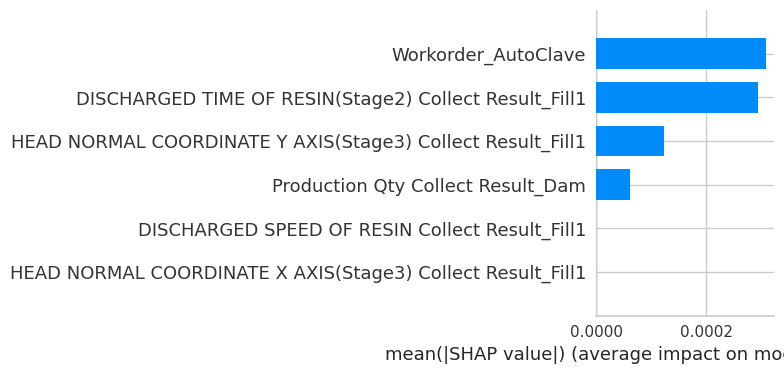

--------------------------------------------------------------------------------


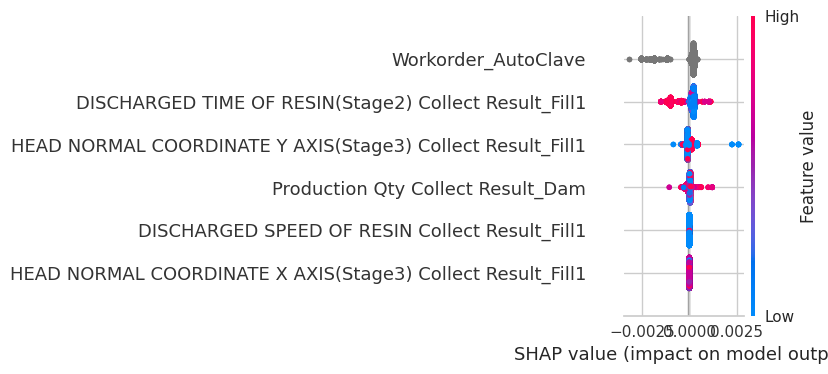

In [ ]:
import shap
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 시스템에 있는 기본 폰트로 폰트 설정
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
if font_list:
    plt.rcParams['font.family'] = fm.FontProperties(fname=font_list[0]).get_name()

# 분석 결과 feature importance 확인
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_valid)

# feature importance plot
shap.summary_plot(shap_values, X_train, plot_type="bar",
                class_names= y_train.unique(), feature_names = X_train.columns)


print("-" * 80)
# visualize
shap.summary_plot(shap_values, X_valid)